<a href="https://colab.research.google.com/github/aartijadhav25/aartijadhav25/blob/main/Cat_Vs_Dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.applications import MobileNetV2


In [2]:
!mkdir -p ~/.kaggle
!cp kaggle-2.json ~/.kaggle/

cp: cannot stat 'kaggle-2.json': No such file or directory


In [3]:
try:
  import kagglehub
except ImportError:
  !pip install kagglehub
path = kagglehub.dataset_download("ashfakyeafi/cat-dog-images-for-classification")

print("Path to dataset files:", path)

100%|██████████| 545M/545M [00:03<00:00, 175MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ashfakyeafi/cat-dog-images-for-classification/versions/2


In [4]:
!kaggle datasets download -d ashfakyeafi/cat-dog-images-for-classification

Dataset URL: https://www.kaggle.com/datasets/ashfakyeafi/cat-dog-images-for-classification
License(s): CC0-1.0
 97% 529M/545M [00:03<00:00, 206MB/s]
100% 545M/545M [00:03<00:00, 178MB/s]


In [5]:
import zipfile
zip_ref = zipfile.ZipFile('/content/cat-dog-images-for-classification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()


In [6]:
data=pd.read_csv('/content/cat_dog.csv')

In [7]:
data.head()

image  labels
0  dog.11289.jpg       1
1  cat.10836.jpg       0
2   cat.7970.jpg       0
3   cat.2212.jpg       0
4   dog.2653.jpg       1

In [8]:
# Add the full image path to the DataFrame
data["image_path"] = data["image"].apply(lambda x: os.path.join("/content/cat_dog", x))

# Filter out files that are not present in the directory
data = data[data["image_path"].apply(os.path.exists)]

# Split the data into training, validation, and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data["labels"], random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=train_data["labels"], random_state=42)

In [9]:

# Data generators for memory efficiency
image_size = (128, 128)
batch_size = 32

# Data Augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [10]:

def preprocess_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, image_size)
    img = img / 255.0
    return img, label


In [11]:
# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_data["image_path"].values, train_data["labels"].values))
train_dataset = train_dataset.map(preprocess_image).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_data["image_path"].values, val_data["labels"].values))
val_dataset = val_dataset.map(preprocess_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_data["image_path"].values, test_data["labels"].values))
test_dataset = test_dataset.map(preprocess_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [12]:
# Build a CNN model
model1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [13]:
# Compile the model with a reduced learning rate
optimizer = Adam(learning_rate=0.0001)
model1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks for Early Stopping and Learning Rate Reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Train the model
history = model1.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 35s 51ms/step - accuracy: 0.6402 - loss: 4.2485 - val_accuracy: 0.6432 - val_loss: 3.2227 - learning_rate: 1.0000e-04
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 37s 53ms/step - accuracy: 0.7424 - loss: 2.8774 - val_accuracy: 0.7527 - val_loss: 2.2713 - learning_rate: 1.0000e-04
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 24s 47ms/step - accuracy: 0.7967 - loss: 2.0626 - val_accuracy: 0.7868 - val_loss: 1.7089 - learning_rate: 1.0000e-04
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 26s 49ms/step - accuracy: 0.8273 - loss: 1.5704 - val_accuracy: 0.7820 - val_loss: 1.4272 - learning_rate: 1.0000e-04
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.8444 - loss: 1.2826 - val_accuracy: 0.8115 - val_loss: 1.2290 - learning_rate: 1.0000e-04
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.8731 - loss: 1.0858 - val_accuracy: 0.8307 - val_loss: 1.1171 - learning_rate: 1.0000e-04
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/ste

In [14]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,916,101 (37.83 MB)

 Trainable params: 3,305,217 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 6,610,436 (25.22 MB)

In [15]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model1.evaluate(test_dataset, verbose=1)
print(f"Test Accuracy: {test_accuracy:.2f}, Test Loss: {test_loss:.2f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.8826 - loss: 0.5355
Test Accuracy: 0.88, Test Loss: 0.53


In [16]:
# Sample 50 images from the test dataset
sample_dataset = test_dataset.unbatch().take(100)

In [17]:
# Prepare lists to store images, true labels, and predictions
images, true_labels, predictions = [], [], []

In [18]:
for img, label in sample_dataset:
    images.append(img.numpy())
    true_labels.append(label.numpy())
    prediction = model1.predict(tf.expand_dims(img, axis=0))[0][0]
    predictions.append(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━

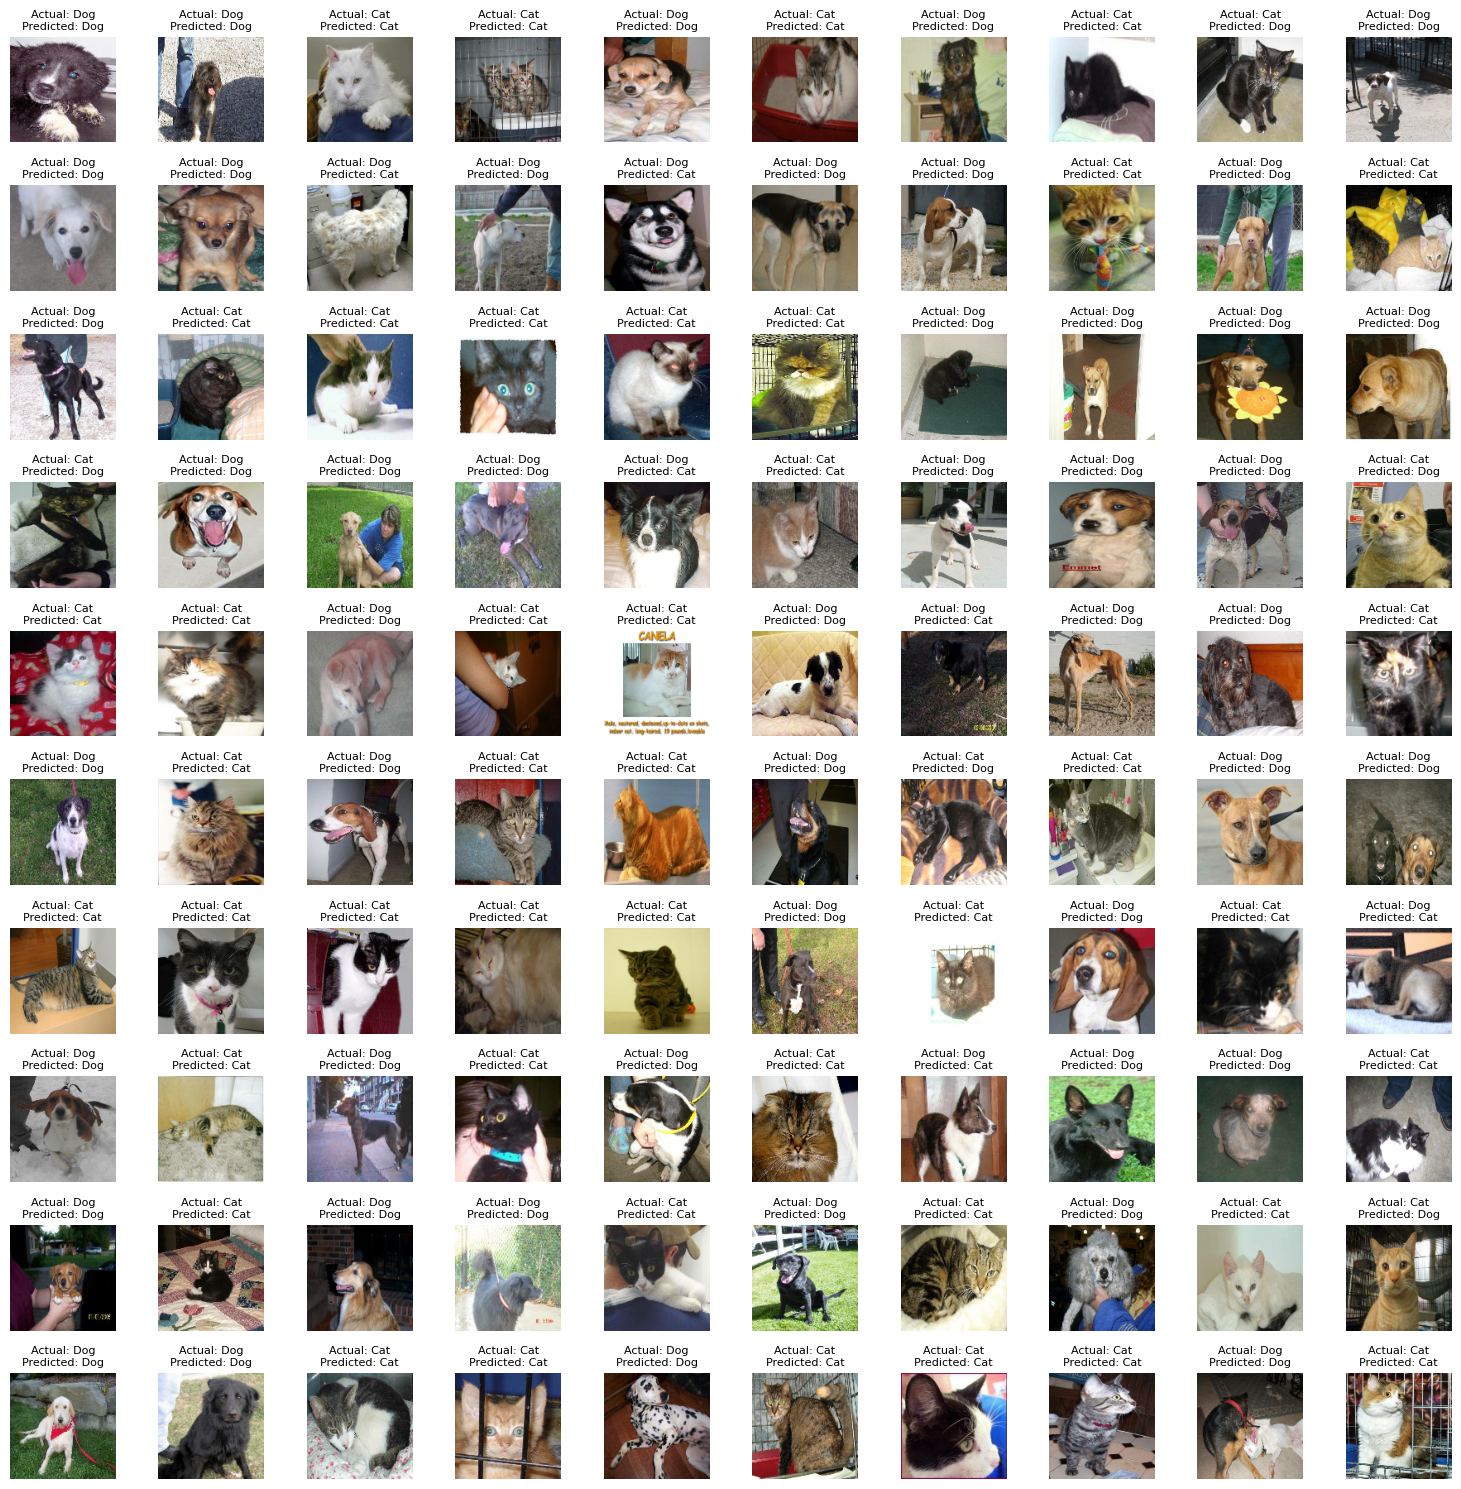

In [21]:
# Plot the 10x10 grid
fig, axes = plt.subplots(10, 10, figsize=(15, 15))
axes = axes.flatten()

for i in range(100):
    ax = axes[i]
    ax.imshow(images[i])
    ax.axis('off')

    true_label = "Dog" if true_labels[i] == 1 else "Cat"
    predicted_label = "Dog" if predictions[i] > 0.5 else "Cat"
    ax.set_title(f"Actual: {true_label}\nPredicted: {predicted_label}", fontsize=8)

plt.tight_layout()
plt.show()


In [22]:
# Use MobileNetV2 for transfer learning
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [23]:
#Build the model
model2 = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02)),
    Dropout(0.6),
    Dense(1, activation='sigmoid')
])

In [24]:
# Compile the model
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Reduced learning rate
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [25]:
# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)


In [26]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

In [27]:
# Train the model
history = model2.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 37s 53ms/step - accuracy: 0.9288 - loss: 3.6509 - val_accuracy: 0.9675 - val_loss: 1.4357 - learning_rate: 1.0000e-04
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 34s 49ms/step - accuracy: 0.9656 - loss: 1.1879 - val_accuracy: 0.9643 - val_loss: 0.6611 - learning_rate: 1.0000e-04
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 38s 43ms/step - accuracy: 0.9656 - loss: 0.5782 - val_accuracy: 0.9625 - val_loss: 0.3993 - learning_rate: 1.0000e-04
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.9692 - loss: 0.3491 - val_accuracy: 0.9617 - val_loss: 0.2929 - learning_rate: 1.0000e-04
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.9709 - loss: 0.2633 - val_accuracy: 0.9645 - val_loss: 0.2392 - learning_rate: 1.0000e-04
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - accuracy: 0.9645 - loss: 0.2324 - val_accuracy: 0.9638 - val_loss: 0.2202 - learning_rate: 1.0000e-04
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 45s 58ms/ste

In [28]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 20480)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       2,621,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,123,077 (38.62 MB)

 Trainable params: 2,621,697 (10.00 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 5,243,396 (20.00 MB)

In [29]:
#Evaluate the model on the test dataset
test_loss, test_accuracy = model2.evaluate(test_dataset, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%, Test Loss: {test_loss:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.9703 - loss: 0.1141
Test Accuracy: 97.24%, Test Loss: 0.1113


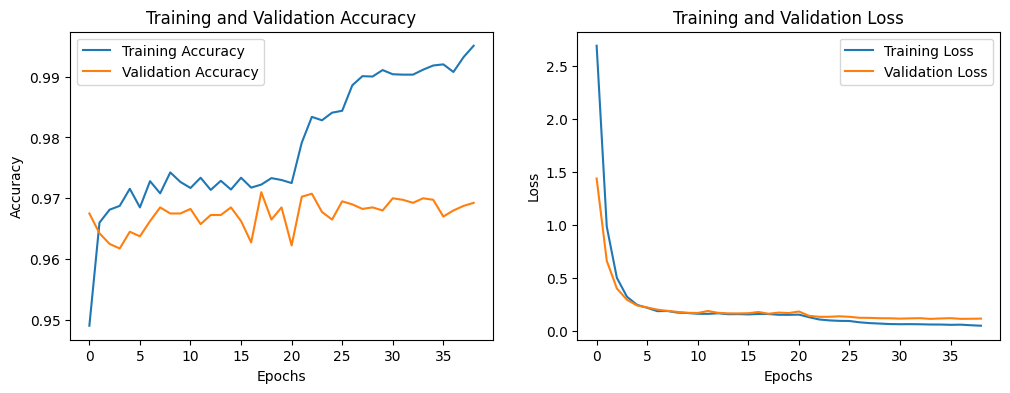

In [30]:
# Plot training and validation curves
def plot_learning_curves(history):
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

plot_learning_curves(history)

In [31]:
# Sample 100 images from the test dataset
sample_dataset = test_dataset.unbatch().take(100)

# Prepare lists to store images, true labels, and predictions
images, true_labels, predictions = [], [], []

# Collect the images, true labels, and predictions
for img, label in sample_dataset:
    images.append(img.numpy())
    true_labels.append(label.numpy())
    prediction = model2.predict(tf.expand_dims(img, axis=0))[0][0]
    predictions.append(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━

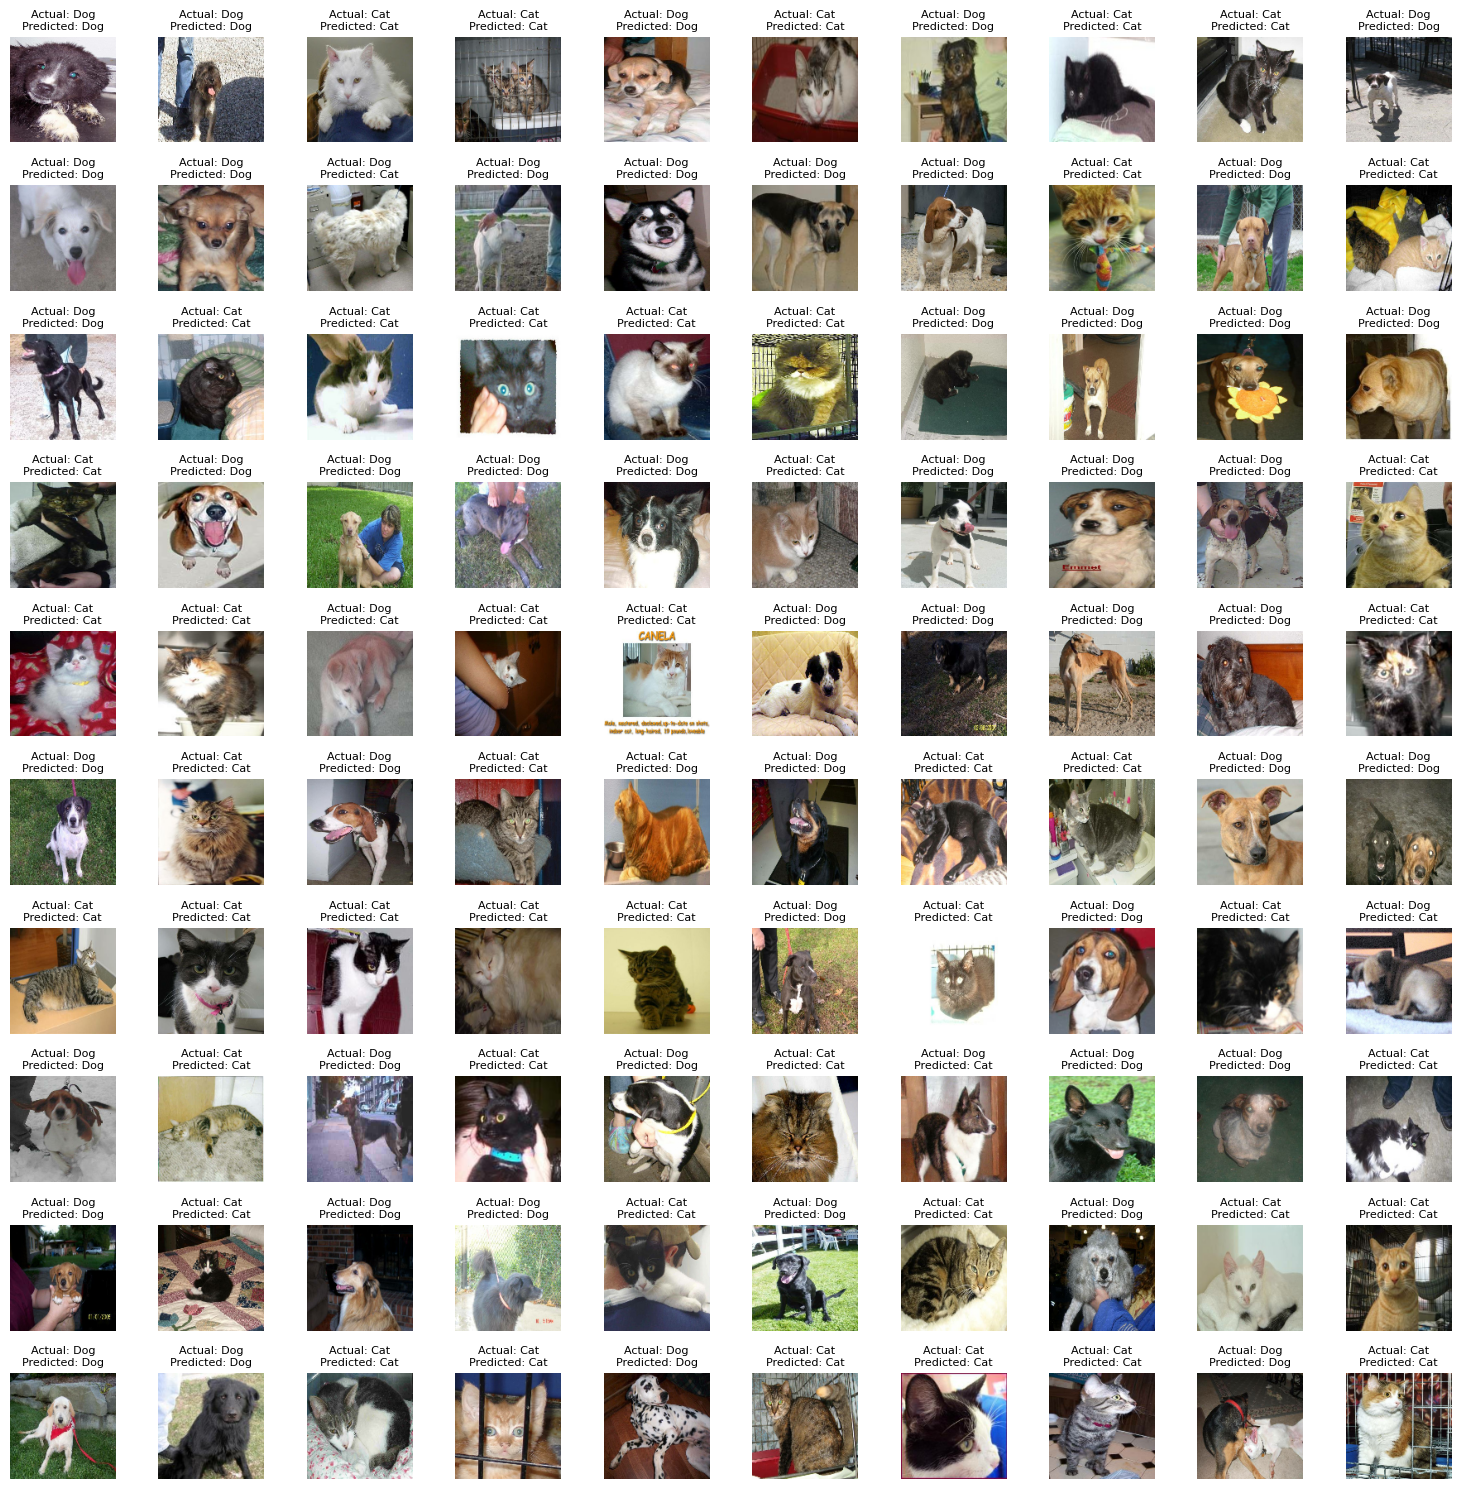

In [32]:
# Plot the 10x10 grid
fig, axes = plt.subplots(10, 10, figsize=(15, 15))
axes = axes.flatten()

for i in range(100):
    ax = axes[i]
    ax.imshow(images[i])
    ax.axis('off')

    true_label = "Dog" if true_labels[i] == 1 else "Cat"
    predicted_label = "Dog" if predictions[i] > 0.5 else "Cat"
    ax.set_title(f"Actual: {true_label}\nPredicted: {predicted_label}", fontsize=8)

plt.tight_layout()
plt.show()

In [33]:
import tensorflow as tf
import matplotlib.pyplot as plt

def preprocess_single_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (128, 128))
    img = img / 255.0
    return tf.expand_dims(img, axis=0)

def predict_and_display(image_path, model):
    processed_img = preprocess_single_image(image_path)

    prediction = model.predict(processed_img)[0][0]
    predicted_label = "Dog" if prediction > 0.5 else "Cat"

    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    plt.imshow(img.numpy())
    plt.axis('off')
    plt.title(f"Predicted: {predicted_label}")
    plt.show()


In [39]:
image_paths = [
    "/content/download (3).jpg",
    "/content/cat2.jpg",
    "/content/cat2.jpg",
    "/content/download dog image.jpg",
    "/content/dog2.jpg",
    "/content/dog3.jpg"



]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


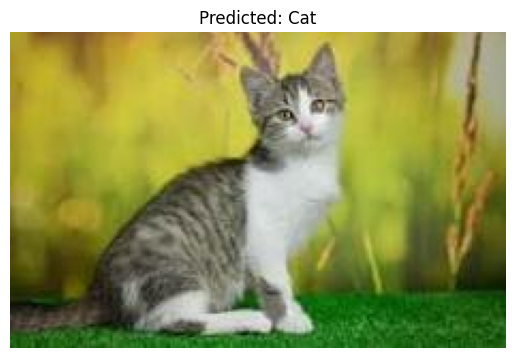

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


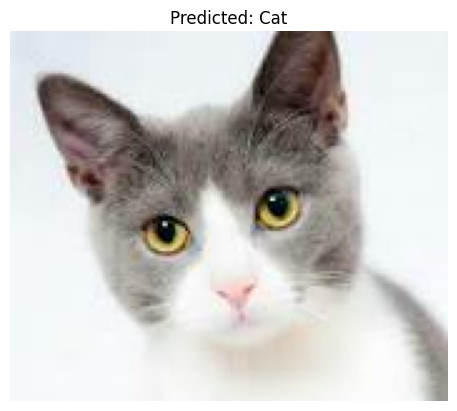

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


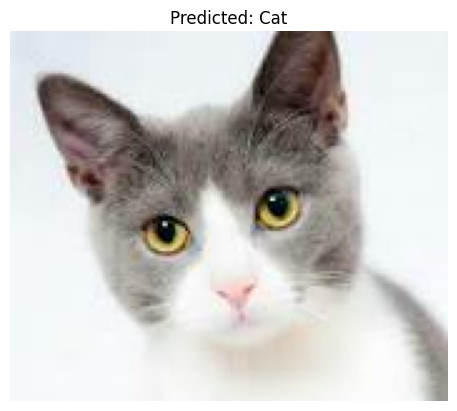

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


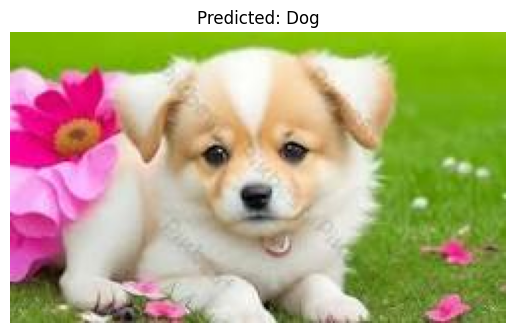

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


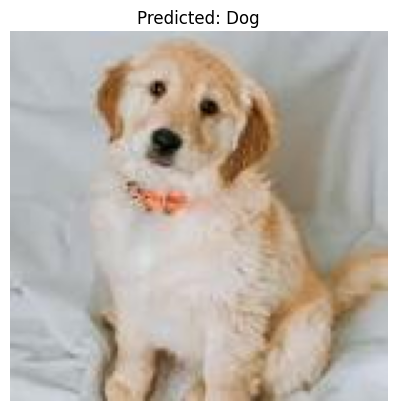

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


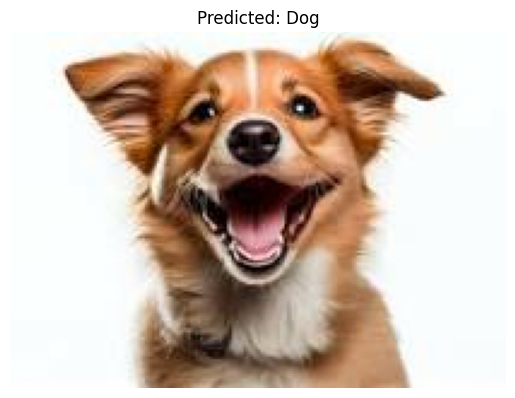

In [40]:
# using model1 to predict cat or dog
for img_path in image_paths:
    predict_and_display(img_path, model1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


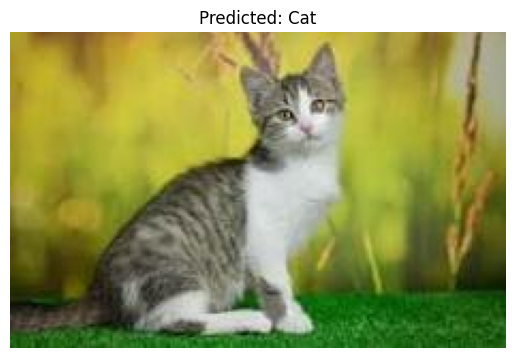

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


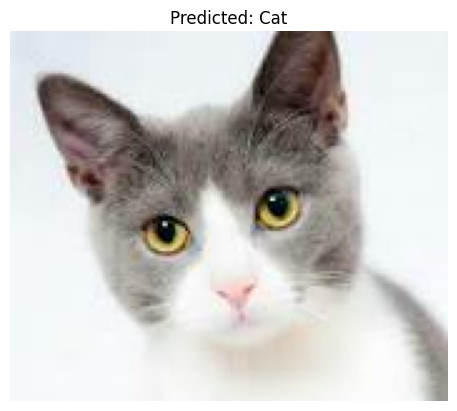

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


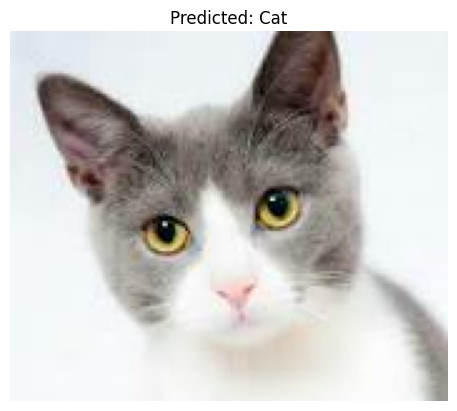

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


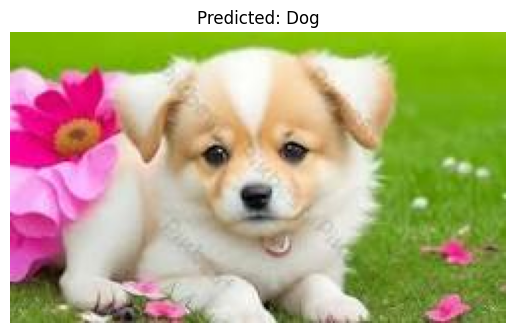

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


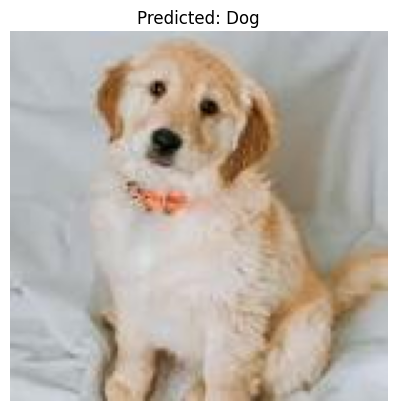

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


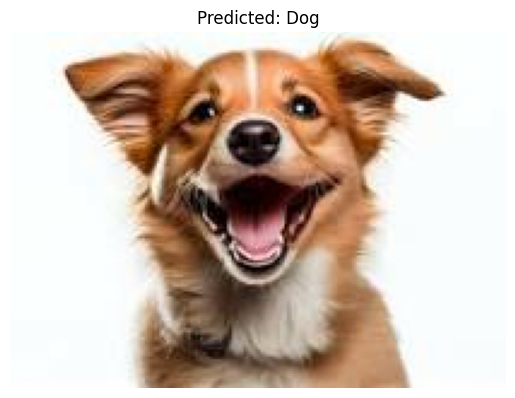

In [41]:
# using model2 to predict cat or dog

for img_path in image_paths:
    predict_and_display(img_path, model2)